In [38]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.animation as animation
import glob, re

import scienceplots
plt.style.use('default')
plt.style.use(['science', 'high-vis', 'grid'])

In [39]:
def rastrigin(x):
    x = np.array(x)
    return 10*len(x) + np.sum(x**2 - 10*np.cos(2*np.pi*x))

In [40]:
DIR = "../build/ParticleSwarmResults"
part_files = glob.glob(DIR + "/part*.csv")
part_files.sort(key=lambda f: int(re.sub('\D', '', f)))

print(f"Found {len(part_files)} files")

Found 16 files


In [41]:
NbPart = len(part_files)
Data0 = np.loadtxt(part_files[0], delimiter=',', skiprows=1)
print(Data0.shape)
# Data is iter, x0, x1, ..., xN, v0, v1, ..., vN, best_x0, best_x1, ..., best_xN, best_f
Dim = int((Data0.shape[1] - 2) / 3)
NbIter = Data0.shape[0]
print(f"Dimension: {Dim}, NbIter: {NbIter}")

NB_PART = len(part_files)
NbPart = NB_PART
part_files = part_files[:NB_PART]

X = np.zeros((NbIter, NbPart, Dim))
V = np.zeros((NbIter, NbPart, Dim))
BestX = np.zeros((NbIter, NbPart, Dim))
BestF = np.zeros((NbIter, NbPart))

for i, f in enumerate(part_files):
    Data = np.loadtxt(f, delimiter=',', skiprows=1)
    X[:,i,:] = Data[:,1:Dim+1]
    V[:,i,:] = Data[:,Dim+1:2*Dim+1]
    BestX[:,i,:] = Data[:,2*Dim+1:3*Dim+1]
    BestF[:,i] = Data[:,3*Dim+1]

    

(51, 8)
Dimension: 2, NbIter: 51


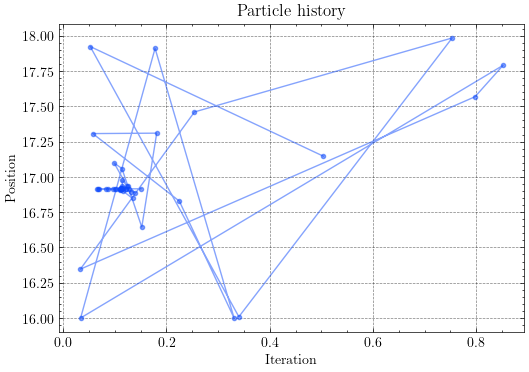

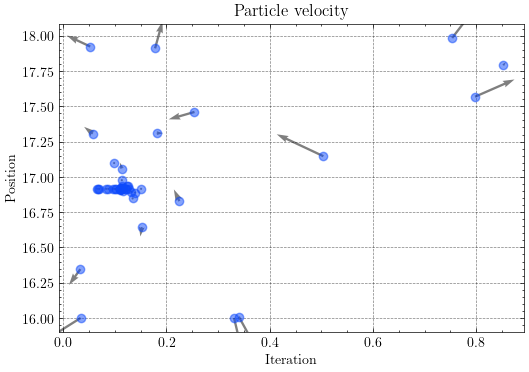

In [42]:
# Plot the history of the first particle
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("Iteration")
ax.set_ylabel("Position")
ax.set_title("Particle history")
ax.plot(X[:,0,0], X[:,0,1], '.-', alpha=0.5, label="Position")

# Quiver plot of the velocity of the first particle
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("Iteration")
ax.set_ylabel("Position")
ax.set_title("Particle velocity")
ax.quiver(X[:,0,0], X[:,0,1], V[:,0,0], V[:,0,1], alpha=0.5, label="Velocity", scale=10, scale_units='xy', angles='xy', width=0.005)
ax.scatter(X[:,0,0], X[:,0,1], alpha=0.5, label="Position")


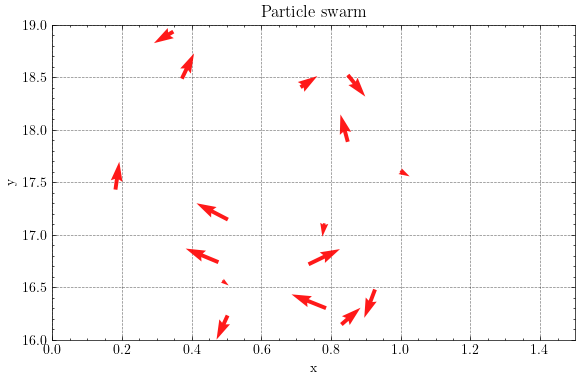

Animation: 50/51

In [43]:
# Animate the particles

BnD = 12
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Particle swarm")
ax.set_xlim(0, 1.5)
ax.set_ylim(16, 19)
# ax.set_aspect('equal')
fig.tight_layout()

line, = ax.plot([], [], 'o', alpha=0.9, markersize=2, color='k')
qr = ax.quiver(X[0,:,0], X[0,:,1], V[0,:,0], V[0,:,1], color='r', alpha=0.9, angles='xy', scale_units='xy', scale=10)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    print(f"\rAnimation: {i}/{NbIter}", end="")
    line.set_data(X[i,:,0], X[i,:,1])
    qr.set_offsets(X[i,:,:])
    qr.set_UVC(V[i,:,0], V[i,:,1])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(V), interval=100, blit=True)
plt.show()
anim.save('../build/ParticleSwarmAnimation.mp4', fps=10, extra_args=['-vcodec', 'libx264'], dpi=300)

In [44]:
V[0,:,0]

array([-0.902832,  0.110244, -0.31752 ,  0.275339, -0.94064 , -0.308566,
        0.550227,  0.186343, -0.211306, -0.054812,  0.500697,  0.481463,
       -0.556222, -0.990995,  0.349703,  0.902693])

In [30]:
X[-1,:,1]

array([19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19.,
       19., 19., 19.])